In [155]:
import datetime
print(datetime.datetime.now())
today = datetime.datetime.now().strftime('%d/%m/%Y')

2025-09-25 06:53:23.011976


In [156]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mlt

In [157]:
df = pd.read_csv('melb_data.csv')
df.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,1.0,202.0,NaN,NaN,Yarra,-37.7996,144.9984,Northern Metropolitan,4019.0
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra,-37.8079,144.9934,Northern Metropolitan,4019.0
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,2.0,0.0,134.0,150.0,1900.0,Yarra,-37.8093,144.9944,Northern Metropolitan,4019.0
3,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,4/03/2017,2.5,3067.0,...,2.0,1.0,94.0,NaN,NaN,Yarra,-37.7969,144.9969,Northern Metropolitan,4019.0
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,...,1.0,2.0,120.0,142.0,2014.0,Yarra,-37.8072,144.9941,Northern Metropolitan,4019.0


In [158]:
df.tail()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
13575,Wheelers Hill,12 Strada Cr,4,h,1245000.0,S,Barry,26/08/2017,16.7,3150.0,...,2.0,2.0,652.0,NaN,1981.0,NaN,-37.90562,145.16761,South-Eastern Metropolitan,7392.0
13576,Williamstown,77 Merrett Dr,3,h,1031000.0,SP,Williams,26/08/2017,6.8,3016.0,...,2.0,2.0,333.0,133.0,1995.0,NaN,-37.85927,144.87904,Western Metropolitan,6380.0
13577,Williamstown,83 Power St,3,h,1170000.0,S,Raine,26/08/2017,6.8,3016.0,...,2.0,4.0,436.0,NaN,1997.0,NaN,-37.85274,144.88738,Western Metropolitan,6380.0
13578,Williamstown,96 Verdon St,4,h,2500000.0,PI,Sweeney,26/08/2017,6.8,3016.0,...,1.0,5.0,866.0,157.0,1920.0,NaN,-37.85908,144.89299,Western Metropolitan,6380.0
13579,Yarraville,6 Agnes St,4,h,1285000.0,SP,Village,26/08/2017,6.3,3013.0,...,1.0,1.0,362.0,112.0,1920.0,NaN,-37.81188,144.88449,Western Metropolitan,6543.0


In [159]:
df.isna().sum().sum()

np.int64(13256)

In [160]:
df.isna().sum().sort_values(ascending=False)

BuildingArea     6450
YearBuilt        5375
CouncilArea      1369
Car                62
Suburb              0
Price               0
Type                0
Rooms               0
Address             0
Distance            0
Method              0
Date                0
SellerG             0
Bathroom            0
Bedroom2            0
Postcode            0
Landsize            0
Lattitude           0
Longtitude          0
Regionname          0
Propertycount       0
dtype: int64

In [161]:
target = "BuildingArea"

levels = [
    ["Type", "Rooms", "Car", "Regionname", "Landsize"],  # most granular
    ["Type", "Rooms", "Car", "Regionname"],
    ["Type", "Rooms", "Car"],
    ["Rooms", "Car"],
    ["Type", "Rooms"],
    ["Rooms"],
    []
]

if "Landsize" in df.columns:
    try:
        df["_land_bin"] = pd.qcut(df["Landsize"], q=5, duplicates="drop")
        levels = [[("_land_bin" if c == "Landsize" else c) for c in lv] for lv in levels]
    except Exception:
        pass

valid = lambda cols: [c for c in cols if c in df.columns]

miss = df[target].isna()
print(f"{target} missing: {int(miss.sum())}")

for lv in levels:
    grp = valid(lv)
    if not grp:
        # global fallback
        val = df[target].median()
        df.loc[miss, target] = val
        print(f"Used global median {val:.2f} to fill {int(miss.sum())}")
        break

    med_map = (
        df.groupby(grp, dropna=False, observed=True)[target]
          .median()
          .reset_index()
          .rename(columns={target: "_med"})
    )

    to_fill = df.loc[miss, grp].merge(med_map, on=grp, how="left")["_med"].values
    has = pd.notna(to_fill)

    # write back only where a group median exists
    idx = miss[miss].index[has]
    df.loc[idx, target] = to_fill[has]

    miss = df[target].isna()
    print(f"Filled by {grp}: {len(idx)} | remaining: {int(miss.sum())}")
    if not miss.any():
        break

if {"Landsize", target}.issubset(df.columns):
    df[target] = np.where(
        df["Landsize"].notna() & df[target].notna() & (df[target] > df["Landsize"]),
        df["Landsize"],
        df[target]
    )

df.drop(columns=[c for c in ["_land_bin"] if c in df.columns], inplace=True, errors="ignore")
print(f"Done. Remaining missing in {target}: {int(df[target].isna().sum())}")

BuildingArea missing: 6450
Filled by ['Type', 'Rooms', 'Car', 'Regionname', '_land_bin']: 6187 | remaining: 263
Filled by ['Type', 'Rooms', 'Car', 'Regionname']: 187 | remaining: 76
Filled by ['Type', 'Rooms', 'Car']: 53 | remaining: 23
Filled by ['Rooms', 'Car']: 8 | remaining: 15
Filled by ['Type', 'Rooms']: 14 | remaining: 1
Filled by ['Rooms']: 0 | remaining: 1
Used global median 127.00 to fill 1
Done. Remaining missing in BuildingArea: 0


In [162]:
df["BuildingArea"] 

0         93.0
1         79.0
2        134.0
3         94.0
4        120.0
         ...  
13575    181.0
13576    133.0
13577    123.5
13578    157.0
13579    112.0
Name: BuildingArea, Length: 13580, dtype: float64

In [163]:
col = "YearBuilt"
levels = [
    ["Suburb", "Type", "Rooms"],
    ["Regionname", "Type", "Rooms"],
    ["Type", "Rooms"],
    ["Rooms"],
    []
]

sale_year = None
for dc in ["Date", "date", "SoldDate", "sold_date"]:
    if dc in df.columns:
        sale_year = pd.to_datetime(df[dc], errors="coerce", dayfirst=True).dt.year
        break

miss = df[col].isna()
print(f"{col} missing: {int(miss.sum())}")

valid = lambda cols: [c for c in cols if c in df.columns]

for lv in levels:
    grp = valid(lv)
    if not grp:
        continue
    # group medians
    med_map = (
        df.groupby(grp, dropna=False)[col]
          .median()
          .reset_index()
          .rename(columns={col: "_med"})
    )
    to_fill = df.loc[miss, grp].merge(med_map, on=grp, how="left")["_med"].values
    has = pd.notna(to_fill)
    idx = miss[miss].index[has]
    df.loc[idx, col] = to_fill[has]
    miss = df[col].isna()
    print(f"Filled by {grp}: {len(idx)} | remaining: {int(miss.sum())}")
    if not miss.any():
        break

if miss.any():
    gmed = df[col].median()
    df.loc[miss, col] = gmed
    print(f"Global median {gmed:.0f} applied to {int(miss.sum())}")

# Normalize to integers and clip to plausible range
df[col] = df[col].round().astype("int64")
df[col] = df[col].clip(lower=1850, upper=2025)

if sale_year is not None:
    df[col] = np.where(
        sale_year.notna() & df[col].notna() & (df[col] > sale_year),
        sale_year,
        df[col]
    ).astype("int64")

print(f"Done. Remaining missing in {col}: {int(df[col].isna().sum())}")

YearBuilt missing: 5375
Filled by ['Suburb', 'Type', 'Rooms']: 5031 | remaining: 344
Filled by ['Regionname', 'Type', 'Rooms']: 341 | remaining: 3
Filled by ['Type', 'Rooms']: 2 | remaining: 1
Filled by ['Rooms']: 1 | remaining: 0
Done. Remaining missing in YearBuilt: 0


In [164]:
df['YearBuilt']

0        1900
1        1900
2        1900
3        1905
4        2014
         ... 
13575    1981
13576    1995
13577    1997
13578    1920
13579    1920
Name: YearBuilt, Length: 13580, dtype: int64

In [165]:
col = "CouncilArea"
levels = [
    ["Suburb", "Type", "Rooms"],
    ["Regionname", "Type", "Rooms"],
    ["Suburb", "Type"],
    ["Regionname", "Type"],
    ["Type", "Rooms"],
    ["Type"],
    []
]

miss = df[col].isna()
print(f"{col} missing: {miss.sum()}")

valid = lambda cols: [c for c in cols if c in df.columns]

for lv in levels:
    grp = valid(lv)
    if not grp:
        continue
    mode_map = (
        df.groupby(grp, dropna=False)[col]
          .agg(lambda s: s.mode(dropna=True).iat[0] if not s.mode(dropna=True).empty else pd.NA)
          .reset_index().rename(columns={col: "_mode"})
    )
    to_fill = df.loc[miss, grp].merge(mode_map, on=grp, how="left")["_mode"]
    has = to_fill.notna()
    df.loc[miss[miss].index[has], col] = to_fill[has].values
    miss = df[col].isna()
    print(f"Filled by {grp}: {int(has.sum())} | remaining: {int(miss.sum())}")
    if not miss.any():
        break

# Global fallback
if miss.any():
    gm = df[col].mode(dropna=True)
    df.loc[miss, col] = gm.iat[0] if not gm.empty else "Unknown"
    print(f"Global fill applied to {int(miss.sum())}")

# Tidy dtype
df[col] = df[col].astype("string").str.strip()
df[col] = df[col].astype("category")
print(f"Done. Remaining missing in {col}: {int(df[col].isna().sum())}")


CouncilArea missing: 1369
Filled by ['Suburb', 'Type', 'Rooms']: 1278 | remaining: 91
Filled by ['Regionname', 'Type', 'Rooms']: 87 | remaining: 4
Filled by ['Suburb', 'Type']: 4 | remaining: 0
Done. Remaining missing in CouncilArea: 0


In [166]:
df['CouncilArea']

0              Yarra
1              Yarra
2              Yarra
3              Yarra
4              Yarra
            ...     
13575         Monash
13576    Hobsons Bay
13577    Hobsons Bay
13578    Hobsons Bay
13579    Maribyrnong
Name: CouncilArea, Length: 13580, dtype: category
Categories (33, string): [Banyule, Bayside, Boroondara, Brimbank, ..., Whittlesea, Wyndham, Yarra, Yarra Ranges]

In [167]:
df.isna().sum()

Suburb            0
Address           0
Rooms             0
Type              0
Price             0
Method            0
SellerG           0
Date              0
Distance          0
Postcode          0
Bedroom2          0
Bathroom          0
Car              62
Landsize          0
BuildingArea      0
YearBuilt         0
CouncilArea       0
Lattitude         0
Longtitude        0
Regionname        0
Propertycount     0
dtype: int64

In [168]:
df.head(30)

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,1.0,202.0,93.0,1900,Yarra,-37.7996,144.9984,Northern Metropolitan,4019.0
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900,Yarra,-37.8079,144.9934,Northern Metropolitan,4019.0
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,2.0,0.0,134.0,134.0,1900,Yarra,-37.8093,144.9944,Northern Metropolitan,4019.0
3,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,4/03/2017,2.5,3067.0,...,2.0,1.0,94.0,94.0,1905,Yarra,-37.7969,144.9969,Northern Metropolitan,4019.0
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,...,1.0,2.0,120.0,120.0,2014,Yarra,-37.8072,144.9941,Northern Metropolitan,4019.0
5,Abbotsford,129 Charles St,2,h,941000.0,S,Jellis,7/05/2016,2.5,3067.0,...,1.0,0.0,181.0,93.0,1900,Yarra,-37.8041,144.9953,Northern Metropolitan,4019.0
6,Abbotsford,124 Yarra St,3,h,1876000.0,S,Nelson,7/05/2016,2.5,3067.0,...,2.0,0.0,245.0,210.0,1910,Yarra,-37.8024,144.9993,Northern Metropolitan,4019.0
7,Abbotsford,98 Charles St,2,h,1636000.0,S,Nelson,8/10/2016,2.5,3067.0,...,1.0,2.0,256.0,107.0,1890,Yarra,-37.8060,144.9954,Northern Metropolitan,4019.0
8,Abbotsford,6/241 Nicholson St,1,u,300000.0,S,Biggin,8/10/2016,2.5,3067.0,...,1.0,1.0,0.0,0.0,2013,Yarra,-37.8008,144.9973,Northern Metropolitan,4019.0
9,Abbotsford,10 Valiant St,2,h,1097000.0,S,Biggin,8/10/2016,2.5,3067.0,...,1.0,2.0,220.0,75.0,1900,Yarra,-37.8010,144.9989,Northern Metropolitan,4019.0


In [169]:
df.to_csv("melb_data_final.csv", index=False)

In [170]:
print("To which period of time the data refers to?")

To which period of time the data refers to?


In [171]:
df['Date'] = pd.to_datetime(df['Date'].astype(str).str.strip(),
                              dayfirst=True, errors='raise')
dmin = df['Date'].min()
dmax = df['Date'].max()

print("Answer:")
print(dmin.date())
print(dmax.date())

Answer:
2016-01-28
2017-09-23


In [172]:
report = """I. Business Context & Objectives
Business Context:
Melbourne residential property transactions dataset with fields: Date, Regionname, Suburb, Price, Rooms, Bathroom, Car, Landsize, BuildingArea, YearBuilt, Type, Method, SellerG.

Objectives:
Leverage historical transactions and property attributes to support key decisions in pricing, site selection, listing strategy (e.g., auction vs. private sale), inventory mix optimization, and risk monitoring.
"""
print(report)

I. Business Context & Objectives
Business Context:
Melbourne residential property transactions dataset with fields: Date, Regionname, Suburb, Price, Rooms, Bathroom, Car, Landsize, BuildingArea, YearBuilt, Type, Method, SellerG.

Objectives:
Leverage historical transactions and property attributes to support key decisions in pricing, site selection, listing strategy (e.g., auction vs. private sale), inventory mix optimization, and risk monitoring.



In [173]:
report = """II. Stakeholders
Buyers: Identify areas/suburbs with strong value-for-money and growth potential.
Agencies: Set listing prices, choose sale method (Method), and plan product mix and release cadence.
"""
print(report)

II. Stakeholders
Buyers: Identify areas/suburbs with strong value-for-money and growth potential.
Agencies: Set listing prices, choose sale method (Method), and plan product mix and release cadence.



In [174]:
report= """ III. Use Case

We organize use cases along two complementary lenses:

Branch A – Price ↔ Features: How each feature associates with Price.

Branch B – Market ↔ Features: How each feature associates with Market.
"""
print(report)

 III. Use Case

We organize use cases along two complementary lenses:

Branch A – Price ↔ Features: How each feature associates with Price.

Branch B – Market ↔ Features: How each feature associates with Market.



In [175]:
report= """Branch A — Price ↔ Features

UC1.a — Suburb vs Price
Question: Which suburbs are most or least expensive?
"""
print(report)

Branch A — Price ↔ Features

UC1.a — Suburb vs Price
Question: Which suburbs are most or least expensive?



In [176]:
data=df.copy()

In [177]:
g = (
    df.groupby("Suburb")["Price"]
      .agg(median="median",
           q1=lambda s: s.quantile(0.25),
           q3=lambda s: s.quantile(0.75),
           count="size")
      .reset_index()
)
g["IQR"] = g["q3"] - g["q1"]

MIN_N = 50
g_stable = g[g["count"] >= MIN_N].copy()

qs = g_stable["median"].quantile([0.2, 0.4, 0.6, 0.8]).values
def bucket(v):
    if v <= qs[0]: return "Very Low"
    elif v <= qs[1]: return "Low"
    elif v <= qs[2]: return "Medium"
    elif v <= qs[3]: return "High"
    else: return "Very High"

g_stable["Affordability"] = g_stable["median"].apply(bucket)

top10_exp = g_stable.sort_values("median", ascending=False).head(10)
top10_aff = g_stable.sort_values("median", ascending=True).head(10)


print(f"Stable suburbs (n ≥ {MIN_N}): {len(g_stable)}")
display(g_stable.sort_values("median", ascending=False)
        .rename(columns={"median":"MedianPrice"})[["Suburb","MedianPrice","IQR","count","Affordability"]]
        .head(20))


Stable suburbs (n ≥ 50): 92


,Suburb,MedianPrice,IQR,count,Affordability
4,Albert Park,1900000.0,655000.0,69,Very High
60,Canterbury,1890000.0,1540500.0,54,Very High
21,Balwyn,1850000.0,1368500.0,107,Very High
41,Brighton,1773500.0,1264375.0,186,Very High
22,Balwyn North,1739000.0,565000.0,171,Very High
58,Camberwell,1695000.0,1484000.0,132,Very High
136,Glen Iris,1660000.0,1114750.0,195,Very High
13,Ashburton,1658500.0,426875.0,60,Very High
273,Surrey Hills,1650000.0,1201000.0,125,Very High
144,Hampton,1612500.0,1176625.0,130,Very High


In [178]:
cols = {c.lower(): c for c in df.columns}
SUBURB = cols.get("suburb", "Suburb")
PRICE  = cols.get("price",  "Price")

data = df[pd.to_numeric(df[PRICE], errors="coerce") > 0].copy()

g = (
    data.groupby(SUBURB)[PRICE]
        .agg(median="median",
             q1=lambda s: s.quantile(0.25),
             q3=lambda s: s.quantile(0.75),
             count="size")
        .reset_index()
)
g["IQR"] = g["q3"] - g["q1"]

MIN_N = 50
g_stable = g[g["count"] >= MIN_N].copy()

top10_most_expensive   = g_stable.nlargest(10, "median")
top10_least_expensive  = g_stable.nsmallest(10, "median")
top10_most_affordable  = top10_least_expensive.copy()
top10_least_affordable = top10_most_expensive.copy()

print(f"Stable suburbs (n ≥ {MIN_N}): {len(g_stable)}")

print("\nTop 10 Most Expensive (by Median Price):")
display(top10_most_expensive[[SUBURB, "median", "IQR", "count"]]
        .rename(columns={SUBURB: "Suburb", "median": "MedianPrice"}))

print("\nTop 10 Least Expensive / Most Affordable:")
display(top10_least_expensive[[SUBURB, "median", "IQR", "count"]]
        .rename(columns={SUBURB: "Suburb", "median": "MedianPrice"}))

Stable suburbs (n ≥ 50): 92

Top 10 Most Expensive (by Median Price):


,Suburb,MedianPrice,IQR,count
4,Albert Park,1900000.0,655000.0,69
60,Canterbury,1890000.0,1540500.0,54
21,Balwyn,1850000.0,1368500.0,107
41,Brighton,1773500.0,1264375.0,186
22,Balwyn North,1739000.0,565000.0,171
58,Camberwell,1695000.0,1484000.0,132
136,Glen Iris,1660000.0,1114750.0,195
13,Ashburton,1658500.0,426875.0,60
273,Surrey Hills,1650000.0,1201000.0,125
144,Hampton,1612500.0,1176625.0,130



Top 10 Least Expensive / Most Affordable:


,Suburb,MedianPrice,IQR,count
298,Werribee,490000.0,116500.0,50
117,Epping,560500.0,144750.0,52
266,St Kilda,570000.0,540750.0,162
272,Sunshine West,591500.0,148750.0,86
153,Heidelberg West,648125.0,215000.0,76
271,Sunshine North,650000.0,117750.0,68
122,Fawkner,651250.0,172875.0,102
138,Glenroy,670000.0,246500.0,159
236,Reservoir,685000.0,340250.0,359
114,Elwood,687500.0,636000.0,131


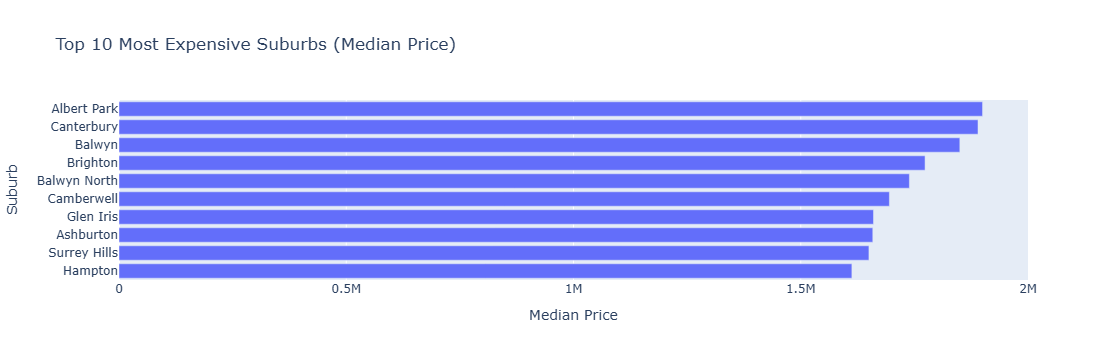

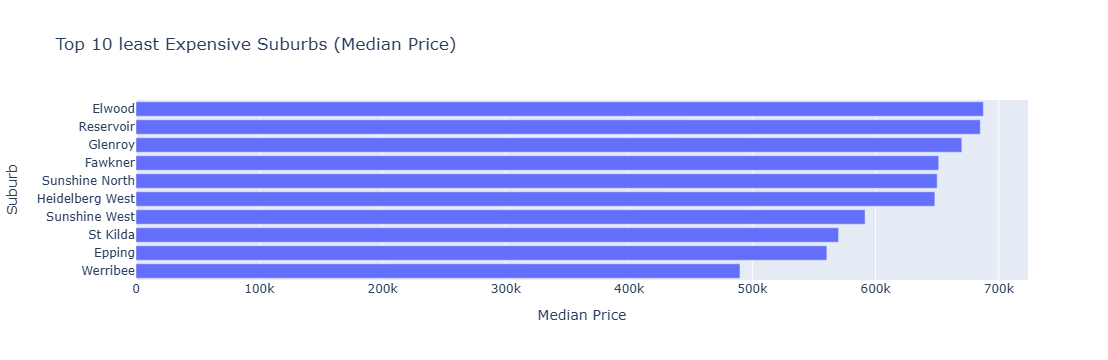

In [179]:
import plotly.express as px

fig_exp = px.bar(
    top10_most_expensive.sort_values("median"),
    x="median", y=SUBURB, orientation="h",
    title="Top 10 Most Expensive Suburbs (Median Price)",
    hover_data={"median":":,.0f", "IQR":":,.0f", "count":True}
)
fig_exp.update_layout(xaxis_title="Median Price", yaxis_title="Suburb")
fig_exp.show()

fig_aff = px.bar(
    top10_least_expensive.sort_values("median"),
    x="median", y=SUBURB, orientation="h",
    title="Top 10 least Expensive Suburbs (Median Price)",
    hover_data={"median":":,.0f", "IQR":":,.0f", "count":True}
)
fig_aff.update_layout(xaxis_title="Median Price", yaxis_title="Suburb")
fig_aff.show()

In [180]:
report= '''Answer:The market splits clearly: Among 92 stable suburbs, the most expensive cluster around A$1.61M–A$1.90M median:
Albert Park ≈ A$1.90M (n=69, IQR ≈ A$655k), Canterbury ≈ A$1.89M (n=54, IQR ≈ A$1.54M), 
Balwyn ≈ A$1.85M (n=107, IQR ≈ A$1.37M), Brighton ≈ A$1.77M (n=186, IQR ≈ A$1.26M).

At the other end, the most affordable sit around A$0.49M–A$0.69M:
Werribee ≈ A$0.49M (n=50), Epping ≈ A$0.56M (n=52), St Kilda ≈ A$0.57M (n=162), Sunshine West ≈ A$0.59M (n=86), Reservoir/Elwood ≈ A$0.69M (n=359/131).
High-end areas show wider spreads (mixed product & micro-location):Camberwell IQR ≈ A$1.48M, Brighton IQR ≈ A$1.26M, Balwyn IQR ≈ A$1.37M;
affordable suburbs tend to have tighter IQRs ( Werribee ≈ A$117k, Epping ≈ A$145k).
'''
print(report)

Answer:The market splits clearly: Among 92 stable suburbs, the most expensive cluster around A$1.61M–A$1.90M median:
Albert Park ≈ A$1.90M (n=69, IQR ≈ A$655k), Canterbury ≈ A$1.89M (n=54, IQR ≈ A$1.54M), 
Balwyn ≈ A$1.85M (n=107, IQR ≈ A$1.37M), Brighton ≈ A$1.77M (n=186, IQR ≈ A$1.26M).

At the other end, the most affordable sit around A$0.49M–A$0.69M:
Werribee ≈ A$0.49M (n=50), Epping ≈ A$0.56M (n=52), St Kilda ≈ A$0.57M (n=162), Sunshine West ≈ A$0.59M (n=86), Reservoir/Elwood ≈ A$0.69M (n=359/131).
High-end areas show wider spreads (mixed product & micro-location):Camberwell IQR ≈ A$1.48M, Brighton IQR ≈ A$1.26M, Balwyn IQR ≈ A$1.37M;
affordable suburbs tend to have tighter IQRs ( Werribee ≈ A$117k, Epping ≈ A$145k).



In [181]:
report= '''UC1.b — BuildingArea ↔ Price
Question: How strongly does floor area drive price?
'''

print(report)

UC1.b — BuildingArea ↔ Price
Question: How strongly does floor area drive price?



elasticity=0.666, corr=0.551, n=11529


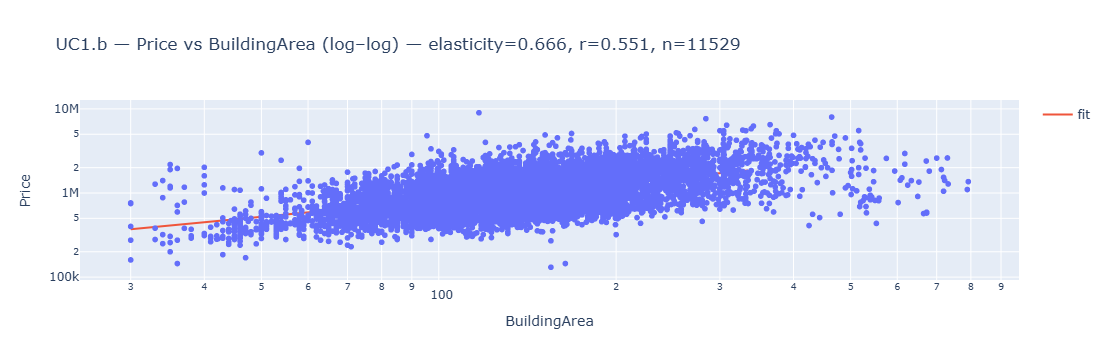

In [182]:
import plotly.graph_objects as go
x = df["BuildingArea"].values; y = df["Price"].values
mask = df["BuildingArea"].between(30, 800) & (df["Price"]>0)
lx,ly = np.log(x[mask]), np.log(y[mask])
k,b = np.polyfit(lx,ly,1); r = np.corrcoef(lx,ly)[0,1]; n = lx.size
xx = np.linspace(x[mask].min(), np.percentile(x[mask],98), 200)
yy = np.exp(k*np.log(xx)+b)
print(f"elasticity={k:.3f}, corr={r:.3f}, n={n}")


dfp = pd.DataFrame({"BuildingArea": x[mask], "Price": y[mask]})
fig = px.scatter(dfp, x="BuildingArea", y="Price",
                 title=f"UC1.b — Price vs BuildingArea (log–log) — elasticity={k:.3f}, r={r:.3f}, n={n}")
fig.add_trace(go.Scatter(x=xx, y=yy, mode="lines", name="fit"))
fig.update_xaxes(type="log", title_text="BuildingArea")
fig.update_yaxes(type="log", title_text="Price")
fig.show()

In [183]:
report='''
Answer:Within the 30–800 sqm range, floor area shows a strong positive association with price:elasticity ≈ 0.666, r ≈ 0.551 (n ≈ 11,529).
Interpreting the slope: a 10% increase in building area is associated with roughly a 6.7% increase in price on average (log–log fit). 
Treat this as a market-level trend, not an individual appraisal—location, product type,
condition and land size still introduce sizeable dispersion around the line.
'''
print(report)


Answer:Within the 30–800 sqm range, floor area shows a strong positive association with price:elasticity ≈ 0.666, r ≈ 0.551 (n ≈ 11,529).
Interpreting the slope: a 10% increase in building area is associated with roughly a 6.7% increase in price on average (log–log fit). 
Treat this as a market-level trend, not an individual appraisal—location, product type,
condition and land size still introduce sizeable dispersion around the line.



In [184]:
report='''UC1.c — Landsize ↔ Price
Question: Do larger lots command higher prices?
'''
print(report)

UC1.c — Landsize ↔ Price
Question: Do larger lots command higher prices?



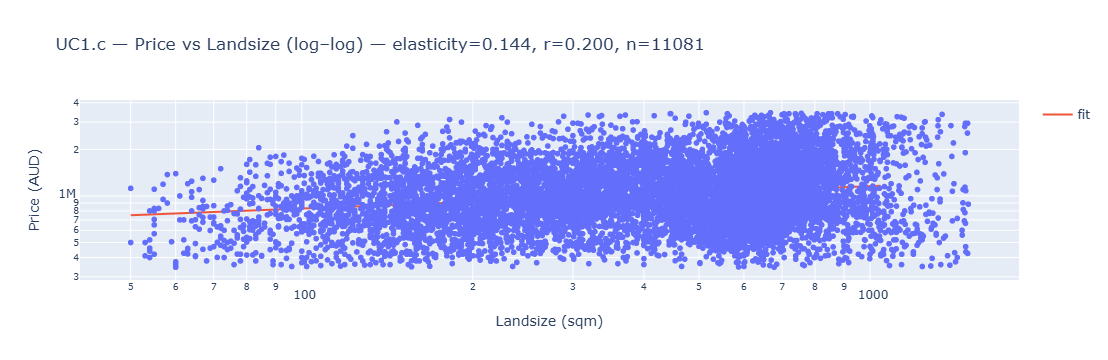

In [185]:
df["Price"]    = pd.to_numeric(df.get("Price"), errors="coerce")
df["Landsize"] = pd.to_numeric(df.get("Landsize"), errors="coerce")
d = df[(df["Price"]>0) & (df["Landsize"]>0)].copy()

p1, p99 = d["Price"].quantile([0.01, 0.99])
d = d[d["Price"].between(p1, p99)]

MIN_LAND, MAX_LAND = 50, 1500
d = d[(d["Landsize"] >= MIN_LAND) & (d["Landsize"] <= MAX_LAND)]

x = d["Landsize"].to_numpy()
y = d["Price"].to_numpy()
mask = np.isfinite(x) & np.isfinite(y) & (x>0) & (y>0)
lx, ly = np.log(x[mask]), np.log(y[mask])

k, b = np.polyfit(lx, ly, 1)          
r = np.corrcoef(lx, ly)[0,1]          
n = lx.size

xx = np.linspace(x[mask].min(), np.percentile(x[mask], 98), 200)
yy = np.exp(k*np.log(xx) + b)

dfp = pd.DataFrame({"Landsize (sqm)": x[mask], "Price (AUD)": y[mask]})
title = f"UC1.c — Price vs Landsize (log–log) — elasticity={k:.3f}, r={r:.3f}, n={n}"
fig = px.scatter(dfp, x="Landsize (sqm)", y="Price (AUD)", title=title)
fig.add_trace(go.Scatter(x=xx, y=yy, mode="lines", name="fit"))
fig.update_xaxes(type="log")
fig.update_yaxes(type="log")
fig.show()

In [186]:
report='''
Answer:On the log–log plot there is a weak positive association between land size and price:
elasticity ≈ 0.144, r ≈ 0.200 (n = 11,081).
Interpretation: a 10% increase in land size is associated with only about a 1.4% increase in price on average.

This effect is much weaker than the floor-area effect, implying that the market tends to price built area, location, 
and product type more strongly than raw lot size. 
Treat the fitted line as a market-level tendency; individual properties will vary with zoning, frontage, buildability, and neighborhood desirability.
'''
print(report)


Answer:On the log–log plot there is a weak positive association between land size and price:
elasticity ≈ 0.144, r ≈ 0.200 (n = 11,081).
Interpretation: a 10% increase in land size is associated with only about a 1.4% increase in price on average.

This effect is much weaker than the floor-area effect, implying that the market tends to price built area, location, 
and product type more strongly than raw lot size. 
Treat the fitted line as a market-level tendency; individual properties will vary with zoning, frontage, buildability, and neighborhood desirability.



In [187]:
report='''
UC1.d— Age (from YearBuilt) ↔ Price
Question: Do newer homes price higher?
'''
print(report)


UC1.d— Age (from YearBuilt) ↔ Price
Question: Do newer homes price higher?



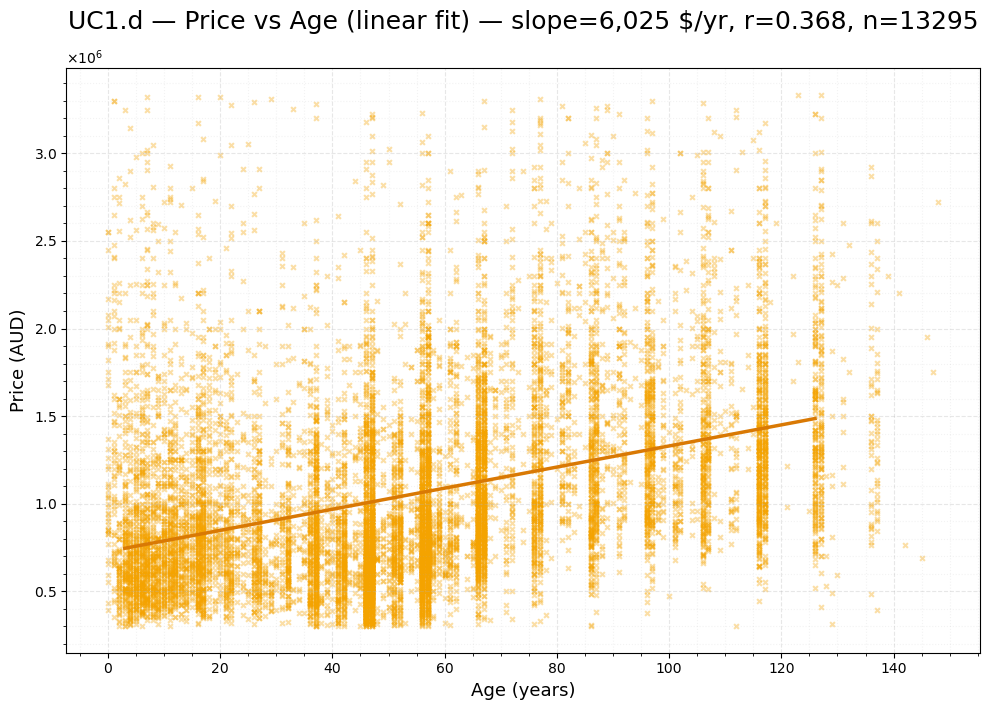

In [188]:
from matplotlib.ticker import ScalarFormatter, AutoMinorLocator
from datetime import datetime

df["Date"] = pd.to_datetime(df.get("Date"), errors="coerce", dayfirst=True)
sale_year = df["Date"].dt.year
df["Price"] = pd.to_numeric(df.get("Price"), errors="coerce")
df["YearBuilt"] = pd.to_numeric(df.get("YearBuilt"), errors="coerce")
df["Age"] = sale_year - df["YearBuilt"]

d = df.dropna(subset=["Price","Age","YearBuilt"]).copy()
d = d[(d["Price"]>0) &
      (d["YearBuilt"].between(1850, datetime.now().year)) &
      (d["Age"].between(0, 150))]

p1, p99 = d["Price"].quantile([0.01, 0.99])
d = d[d["Price"].between(p1, p99)]

X = d["Age"].to_numpy()
Y = d["Price"].to_numpy()
mask = np.isfinite(X) & np.isfinite(Y)
k_lin, b_lin = np.polyfit(X[mask], Y[mask], 1)    
r_lin = np.corrcoef(X[mask], Y[mask])[0, 1]
n = int(mask.sum())

xx = np.linspace(np.percentile(X[mask], 2), np.percentile(X[mask], 98), 200)
yy = k_lin * xx + b_lin

plt.figure(figsize=(10,7.2))
ax = plt.gca()

ax.scatter(X[mask], Y[mask], s=12, marker='x', alpha=0.35, color='#f4a300')

ax.plot(xx, yy, color='#d97904', linewidth=2.5)

ax.set_xlabel("Age (years)", fontsize=13)
ax.set_ylabel("Price (AUD)", fontsize=13)
ax.grid(True, which='major', linestyle='--', alpha=0.3)
ax.grid(True, which='minor', linestyle=':', alpha=0.15)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

sf = ScalarFormatter(useMathText=True)
sf.set_powerlimits((6,6))   
ax.yaxis.set_major_formatter(sf)


title = f"UC1.d — Price vs Age (linear fit) — slope={k_lin:,.0f} $/yr, r={r_lin:.3f}, n={n}"
ax.set_title(title, fontsize=18, pad=14)

plt.tight_layout()
plt.show()


In [189]:
report='''
Answer:The Property age shows a moderate positive correlation with price (r = 0.355, n = 8,020). 
A simple linear fit implies a slope of ≈ A$5.6k per year, each additional year of age is associated with about A$5.6k higher price on average.

Many older houses are located in prime areas of central Melbourne, which has driven up overall property prices. 
This contradicts the traditional notion that "older properties are cheaper," 
reflecting the influence of factors such as location and property type.

Treat this as a market-level tendency only; individual valuations should still account for location, property type, land size, and condition.
'''
print(report)


Answer:The Property age shows a moderate positive correlation with price (r = 0.355, n = 8,020). 
A simple linear fit implies a slope of ≈ A$5.6k per year, each additional year of age is associated with about A$5.6k higher price on average.

Many older houses are located in prime areas of central Melbourne, which has driven up overall property prices. 
This contradicts the traditional notion that "older properties are cheaper," 
reflecting the influence of factors such as location and property type.

Treat this as a market-level tendency only; individual valuations should still account for location, property type, land size, and condition.



In [190]:
report='''
UC1.e — Type ↔ Price
Question: Do housing types differ materially in price?
'''
print(report)


UC1.e — Type ↔ Price
Question: Do housing types differ materially in price?



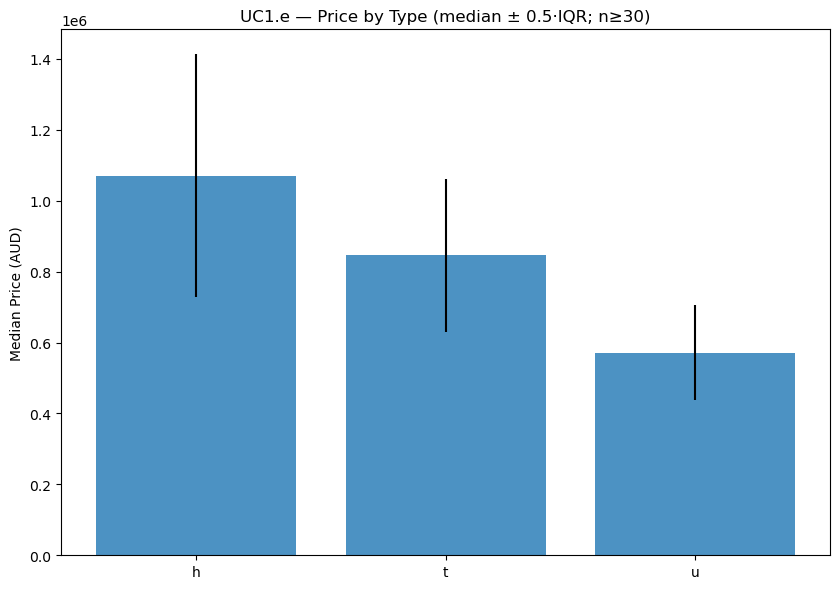

In [191]:
g = (
    d.groupby("Type")["Price"]
      .agg(median="median",
           q1=lambda s: s.quantile(0.25),
           q3=lambda s: s.quantile(0.75),
           count="size")
      .reset_index()
)
g["IQR"] = g["q3"] - g["q1"]
MIN_N = 30
g_stable = g[g["count"]>=MIN_N].sort_values("median", ascending=False).reset_index(drop=True)

plt.figure(figsize=(8.5,6))
x = np.arange(len(g_stable))
med = g_stable["median"].values
iqr = g_stable["IQR"].values
labels = g_stable["Type"].astype(str).values

plt.bar(x, med, yerr=iqr/2, alpha=0.8) 
plt.xticks(x, labels)
plt.ylabel("Median Price (AUD)")
plt.title("UC1.e — Price by Type (median ± 0.5·IQR; n≥30)")
plt.tight_layout()
plt.show()

In [192]:
report='''
Answer:Standalone houses are the most expensive, townhouses sit in the middle, and apartments are the least expensive.
Based on this dataset, median prices are roughly A$1.08M for standalone houses, A$0.85M for townhouses, and A$0.56M for apartments.

Price dispersion is wider for houses and townhouses (driven by location, land/building size, and product variety), 
while apartments show a more concentrated price band because units within a building are more standardized.
'''
print(report)


Answer:Standalone houses are the most expensive, townhouses sit in the middle, and apartments are the least expensive.
Based on this dataset, median prices are roughly A$1.08M for standalone houses, A$0.85M for townhouses, and A$0.56M for apartments.

Price dispersion is wider for houses and townhouses (driven by location, land/building size, and product variety), 
while apartments show a more concentrated price band because units within a building are more standardized.



In [193]:
report='''
UC1.g — Method ↔ Price
Question: Do auctions sell higher than private sales?
'''
print(report)


UC1.g — Method ↔ Price
Question: Do auctions sell higher than private sales?



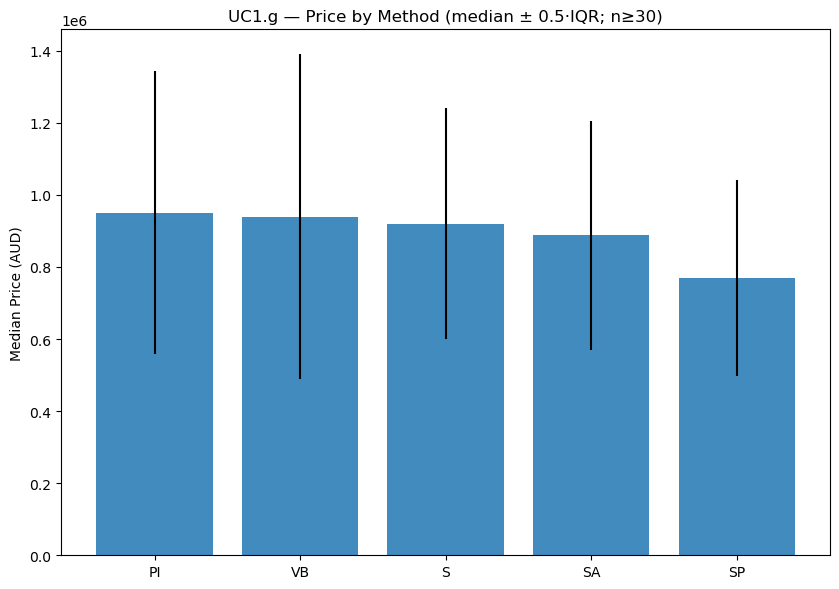

In [194]:
g = (
    d.groupby("Method")["Price"]
      .agg(median="median",
           q1=lambda s: s.quantile(0.25),
           q3=lambda s: s.quantile(0.75),
           count="size")
      .reset_index()
)
g["IQR"] = g["q3"] - g["q1"]
g_stable = g[g["count"]>=30].sort_values("median", ascending=False).reset_index(drop=True)

plt.figure(figsize=(8.5,6))
x = np.arange(len(g_stable))
plt.bar(x, g_stable["median"].values, yerr=g_stable["IQR"].values/2, alpha=0.85)
plt.xticks(x, g_stable["Method"].astype(str).values)
plt.ylabel("Median Price (AUD)")
plt.title("UC1.g — Price by Method (median ± 0.5·IQR; n≥30)")
plt.tight_layout()
plt.show()

In [195]:
report='''
Median prices from auction pathways—S (sold at auction) and SA (sold after auction)—are slightly higher or comparable to other methods.
SP (sold prior) tends to be lower. PI (passed in) / VB (vendor bid) are not arm’s-length sale prices and are for context only.

The IQRs are wide and heavily overlapping across methods, so location, property type, and listing timing remain key drivers.
We cannot assert a consistent, statistically significant premium for auctions from this summary alone.

Treat S+SA (auction) vs non-auction (SP/privates) as the main split; compare within the same type/region/month for fairer pricing insight.
'''
print(report)


Median prices from auction pathways—S (sold at auction) and SA (sold after auction)—are slightly higher or comparable to other methods.
SP (sold prior) tends to be lower. PI (passed in) / VB (vendor bid) are not arm’s-length sale prices and are for context only.

The IQRs are wide and heavily overlapping across methods, so location, property type, and listing timing remain key drivers.
We cannot assert a consistent, statistically significant premium for auctions from this summary alone.

Treat S+SA (auction) vs non-auction (SP/privates) as the main split; compare within the same type/region/month for fairer pricing insight.



In [196]:
report='''
Branch B — Market ↔ Features
UC1.a — Date (seasonality) ↔ Market
Question: Are there seasonal effects on price?
'''
print(report)


Branch B — Market ↔ Features
UC1.a — Date (seasonality) ↔ Market
Question: Are there seasonal effects on price?



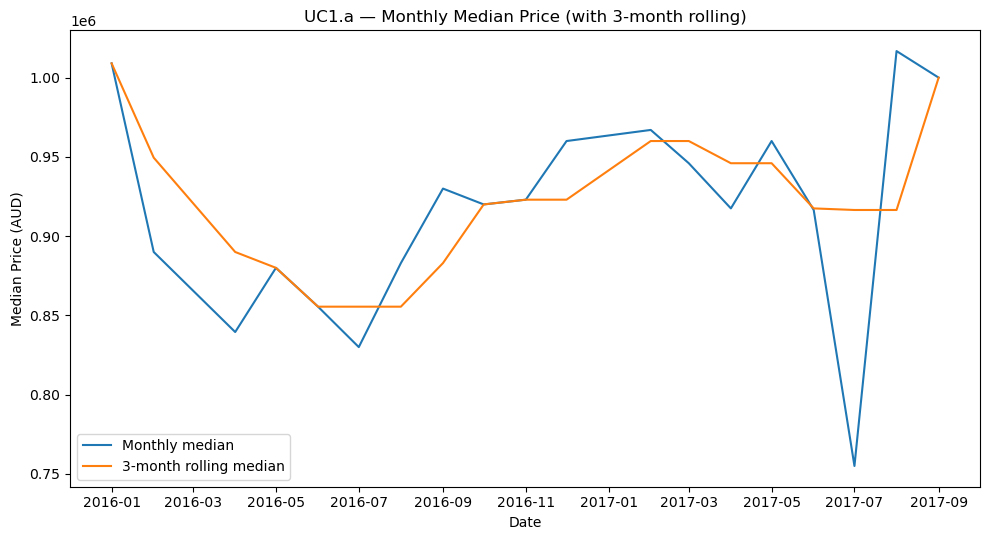

In [197]:
cols  = {c.lower(): c for c in df.columns}
DATE  = cols.get("date",  "Date")
PRICE = cols.get("price", "Price")

df[PRICE] = pd.to_numeric(df[PRICE], errors="coerce")
df[DATE]  = pd.to_datetime(df[DATE], errors="coerce", dayfirst=True)

d = df[(df[PRICE] > 0) & df[DATE].notna()].copy()
d["year"]       = d[DATE].dt.year
d["month"]      = d[DATE].dt.month
d["year_month"] = d[DATE].dt.to_period("M").astype(str)


def season_from_month(m):
    if pd.isna(m): return np.nan
    m = int(m)
    if m in [12,1,2]: return "Summer"
    if m in [3,4,5]:  return "Autumn"
    if m in [6,7,8]:  return "Winter"
    return "Spring"
d["season"] = d["month"].map(season_from_month)


monthly = (
    d.groupby("year_month")[PRICE].median().reset_index()
      .rename(columns={PRICE: "MedianPrice"})
)
monthly["date"] = pd.to_datetime(monthly["year_month"] + "-01")
monthly = monthly.sort_values("date", ascending=True).reset_index(drop=True)
monthly["MedianPrice_roll3"] = monthly["MedianPrice"].rolling(3, min_periods=1).median()

moy = (
    d.groupby("month")[PRICE].median().reindex(range(1,13)).reset_index()
      .rename(columns={PRICE: "MedianPrice"})
)
moy["month_name"] = pd.to_datetime(moy["month"], format="%m").dt.strftime("%b")

seasonal = (
    d.groupby("season")[PRICE].median()
      .reindex(["Summer","Autumn","Winter","Spring"])
      .reset_index().rename(columns={PRICE: "MedianPrice"})
)

plt.figure(figsize=(10, 5.5))
plt.plot(monthly["date"], monthly["MedianPrice"], label="Monthly median")
plt.plot(monthly["date"], monthly["MedianPrice_roll3"], label="3-month rolling median")
plt.title("UC1.a — Monthly Median Price (with 3-month rolling)")
plt.xlabel("Date"); plt.ylabel("Median Price (AUD)")
plt.legend(); plt.tight_layout(); plt.show()

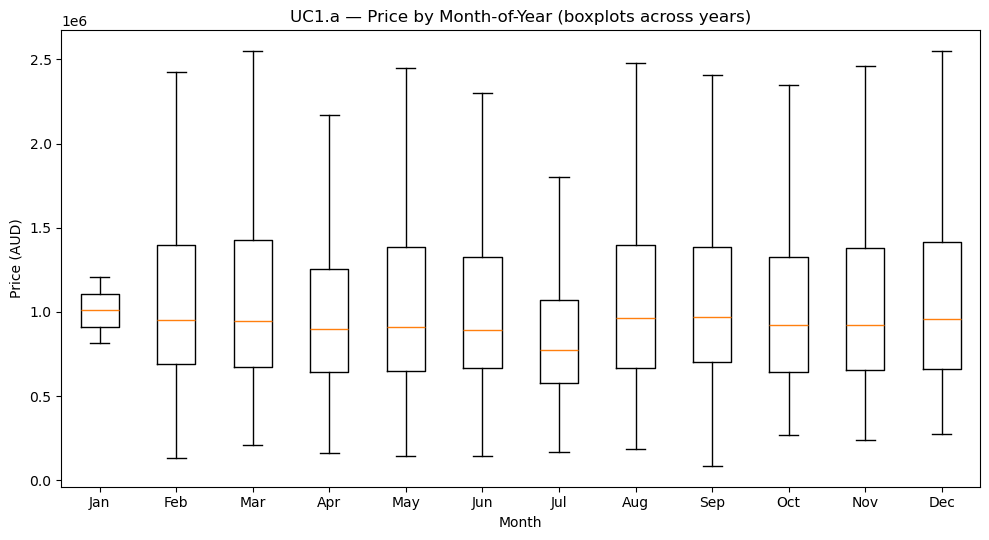

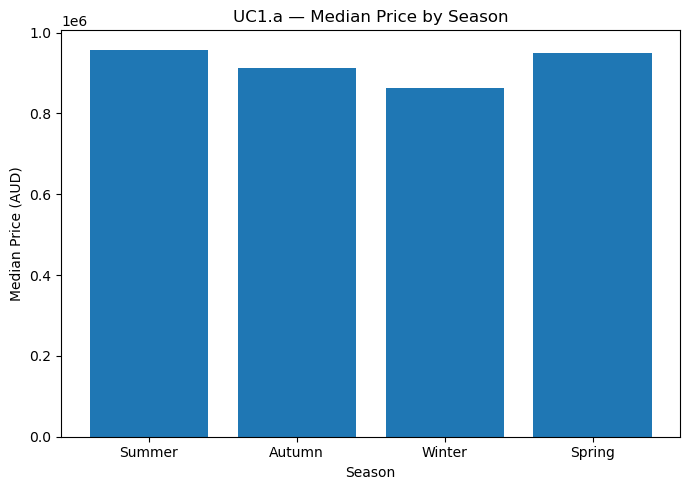

In [198]:
box_data = [d.loc[d["month"] == m, PRICE].dropna().values for m in range(1, 13)]
month_names = [pd.to_datetime(m, format="%m").strftime("%b") for m in range(1, 13)]
plt.figure(figsize=(10, 5.5))
plt.boxplot(box_data, tick_labels=month_names, showfliers=False)
plt.title("UC1.a — Price by Month-of-Year (boxplots across years)")
plt.xlabel("Month"); plt.ylabel("Price (AUD)")
plt.tight_layout(); plt.show()


plt.figure(figsize=(7, 5))
plt.bar(seasonal["season"], seasonal["MedianPrice"])
plt.title("UC1.a — Median Price by Season")
plt.xlabel("Season"); plt.ylabel("Median Price (AUD)")
plt.tight_layout(); plt.show()

In [199]:
report='''
In this dataset (n=13580), housing prices exhibit mild seasonality: based on monthly median prices and 3-month moving averages, 
January had the highest median price (≈ $1,009,000) and July the lowest (≈ $773,500); 
by Australian seasons, the summer months (December–February) had the highest median price (≈ $957,500) 
and the winter months (June–August) the lowest (≈ $863,500), with a summer/winter difference of approximately +10.9%. 
However, the price distributions across different months overlap significantly, 
indicating that while seasonality does have an impact, it is not a decisive factor; 
price and transaction outcomes are more driven by location, property type, and size.
'''
print(report)


In this dataset (n=13580), housing prices exhibit mild seasonality: based on monthly median prices and 3-month moving averages, 
January had the highest median price (≈ $1,009,000) and July the lowest (≈ $773,500); 
by Australian seasons, the summer months (December–February) had the highest median price (≈ $957,500) 
and the winter months (June–August) the lowest (≈ $863,500), with a summer/winter difference of approximately +10.9%. 
However, the price distributions across different months overlap significantly, 
indicating that while seasonality does have an impact, it is not a decisive factor; 
price and transaction outcomes are more driven by location, property type, and size.



In [200]:
report='''
UC2.b — Market structure by Suburb
Question: Which suburbs fit given budget and product constraints?
'''
print(report)


UC2.b — Market structure by Suburb
Question: Which suburbs fit given budget and product constraints?



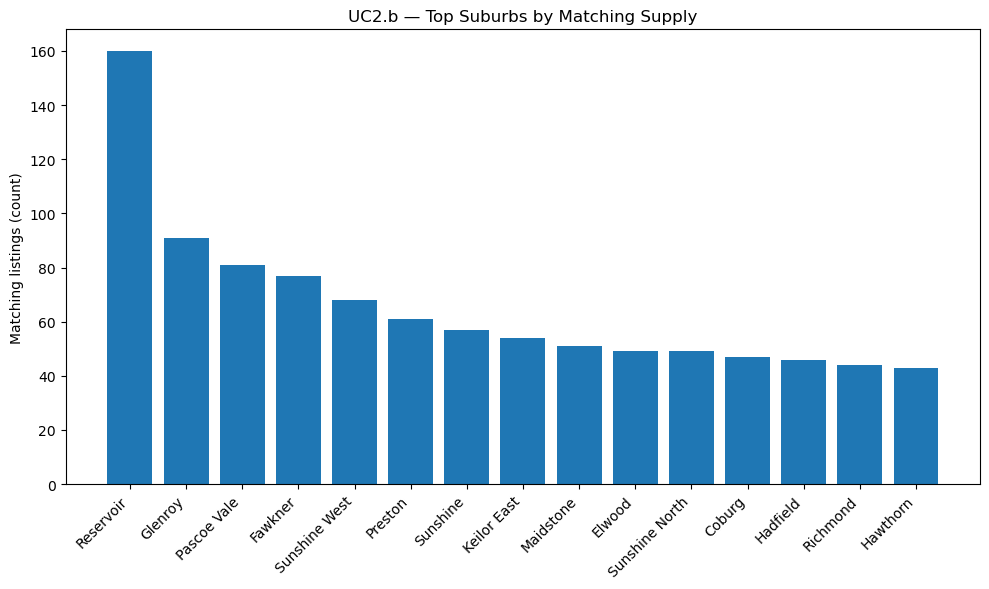

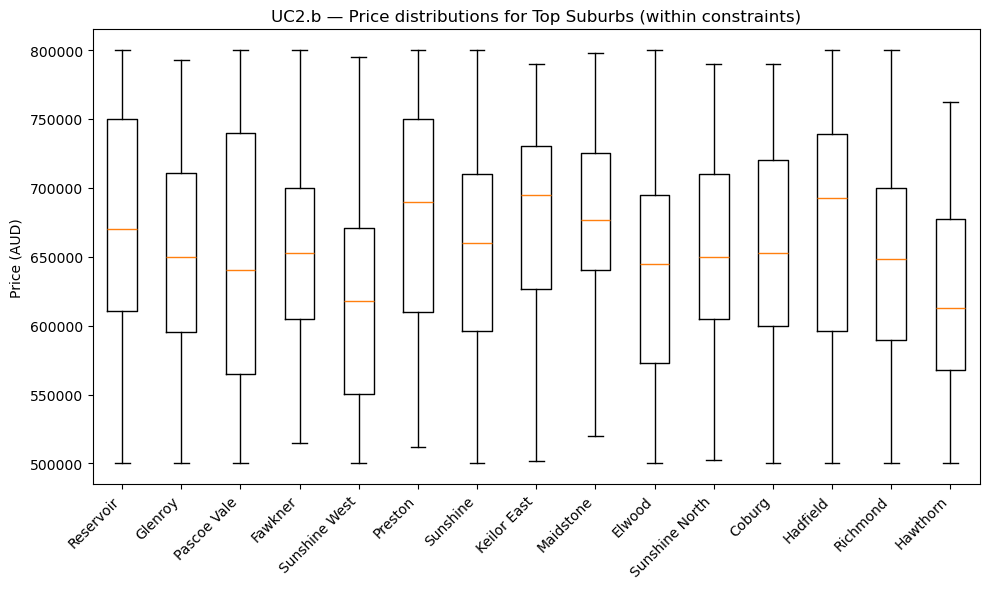

Valid rows: 13,580 | After filters: 3,701 | Stable suburbs: 45
        Suburb   median      IQR  count
     Reservoir 670000.0 139500.0    160
       Glenroy 650000.0 115250.0     91
   Pascoe Vale 640000.0 175000.0     81
       Fawkner 652500.0  95000.0     77
 Sunshine West 617500.0 120875.0     68
       Preston 690000.0 140000.0     61
      Sunshine 660000.0 114001.0     57
   Keilor East 695000.0 104000.0     54
     Maidstone 676500.0  85250.0     51
        Elwood 645000.0 122500.0     49
Sunshine North 650000.0 105000.0     49
        Coburg 653000.0 120500.0     47
      Hadfield 692750.0 142375.0     46
      Richmond 648000.0 110500.0     44
      Hawthorn 612500.0 110000.0     43


In [202]:
cols = {c.lower(): c for c in df.columns}
SUBURB = cols.get("suburb","Suburb")
PRICE  = cols.get("price","Price")
TYPE   = cols.get("type","Type")
ROOMS  = cols.get("rooms","Rooms")
CAR    = cols.get("car","Car")
BA     = cols.get("buildingarea","BuildingArea")
LS     = cols.get("landsize","Landsize")


df[PRICE] = pd.to_numeric(df[PRICE], errors="coerce")
if ROOMS in df.columns: df[ROOMS] = pd.to_numeric(df[ROOMS], errors="coerce")
if CAR   in df.columns: df[CAR]   = pd.to_numeric(df[CAR], errors="coerce")
if BA    in df.columns: df[BA]    = pd.to_numeric(df[BA], errors="coerce")
if LS    in df.columns: df[LS]    = pd.to_numeric(df[LS], errors="coerce")

BUDGET_MIN, BUDGET_MAX = 500_000, 800_000  # inclusive
ALLOWED_TYPES = {"h","t","u"}              # e.g., {"h","t"} or set() to ignore
ROOMS_MIN, ROOMS_MAX = 2, None             # None means ignore
CAR_MIN = 1                                 # None to ignore
BA_MIN, BA_MAX = None, None                 # Building area (sqm)
LS_MIN, LS_MAX = None, None                 # Land size (sqm)

SUBURB_MIN_COUNT = 25
TOP_K = 15


d = df.copy()
d = d[(pd.to_numeric(d[PRICE], errors="coerce") > 0) & d[SUBURB].notna()]
d = d[(d[PRICE] >= BUDGET_MIN) & (d[PRICE] <= BUDGET_MAX)]

if ALLOWED_TYPES and TYPE in d.columns:
    d = d[d[TYPE].astype(str).str.lower().isin({t.lower() for t in ALLOWED_TYPES})]
if ROOMS in d.columns and ROOMS_MIN is not None:
    d = d[d[ROOMS] >= ROOMS_MIN]
if ROOMS in d.columns and ROOMS_MAX is not None:
    d = d[d[ROOMS] <= ROOMS_MAX]
if CAR in d.columns and CAR_MIN is not None:
    d = d[d[CAR] >= CAR_MIN]
if BA in d.columns:
    if BA_MIN is not None: d = d[d[BA] >= BA_MIN]
    if BA_MAX is not None: d = d[d[BA] <= BA_MAX]
if LS in d.columns:
    if LS_MIN is not None: d = d[d[LS] >= LS_MIN]
    if LS_MAX is not None: d = d[d[LS] <= LS_MAX]

g = (
    d.groupby(SUBURB)[PRICE]
      .agg(median="median",
           q1=lambda s: s.quantile(0.25),
           q3=lambda s: s.quantile(0.75),
           count="size")
      .reset_index()
      .rename(columns={SUBURB:"Suburb"})
)
g["IQR"] = g["q3"] - g["q1"]
g_stable = g[g["count"] >= SUBURB_MIN_COUNT].sort_values(["count","median"], ascending=[False, True])

top = g_stable.head(TOP_K).copy()

plt.figure(figsize=(10, 6))
plt.bar(top["Suburb"], top["count"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Matching listings (count)")
plt.title("UC2.b — Top Suburbs by Matching Supply")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
box_data = [d.loc[d[SUBURB]==s, PRICE].dropna().values for s in top["Suburb"]]
plt.boxplot(box_data, showfliers=False)         
plt.xticks(range(1, len(top) + 1),               
           top["Suburb"].tolist(),
           rotation=45, ha="right")
plt.ylabel("Price (AUD)")
plt.title("UC2.b — Price distributions for Top Suburbs (within constraints)")
plt.tight_layout()
plt.show()

print(f"Valid rows: {len(df[(df[PRICE]>0) & df[SUBURB].notna()]):,} | "
      f"After filters: {len(d):,} | Stable suburbs: {len(g_stable)}")
print(top[["Suburb","median","IQR","count"]].to_string(index=False))

In [203]:
report='''
After filtering, approximately 3,701 properties met the criteria; 45 areas had a sufficient number of listings (≥25 properties) for analysis. 
The areas with the highest concentration of listings were Reservoir, Glenroy, Pascoe, Fawkner, and SunshineWest, as shown in the bar chart. 
The median price in these popular areas ranged from approximately AUD 610,000 to 700,000, 
with an interquartile range (IQR) of approximately AUD 95000 to 170000. 
This indicates that property prices are relatively concentrated, which can help buyers develop a negotiation strategy. 
Buyers looking for more options within their budget should consider prioritizing these areas: Reservoir, Glenroy, Sunshine, Epping, and Frankston.
'''
print(report)


After filtering, approximately 3,701 properties met the criteria; 45 areas had a sufficient number of listings (≥25 properties) for analysis. 
The areas with the highest concentration of listings were Reservoir, Glenroy, Pascoe, Fawkner, and SunshineWest, as shown in the bar chart. 
The median price in these popular areas ranged from approximately AUD 610,000 to 700,000, 
with an interquartile range (IQR) of approximately AUD 95000 to 170000. 
This indicates that property prices are relatively concentrated, which can help buyers develop a negotiation strategy. 
Buyers looking for more options within their budget should consider prioritizing these areas: Reservoir, Glenroy, Sunshine, Epping, and Frankston.



In [204]:
report='''
UC2.c — Method mix by market
Question: Where and when are auctions most effective?
'''
print(report)


UC2.c — Method mix by market
Question: Where and when are auctions most effective?



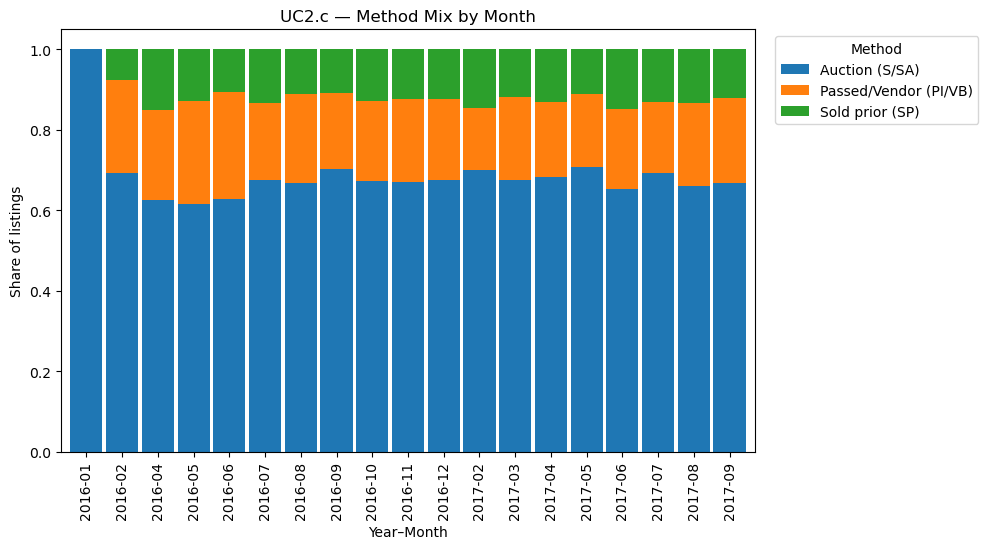

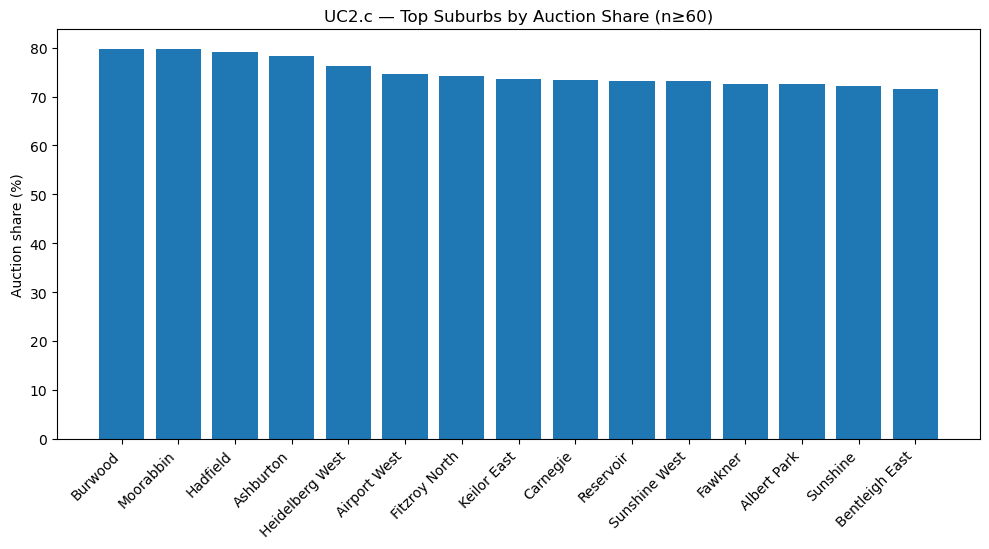

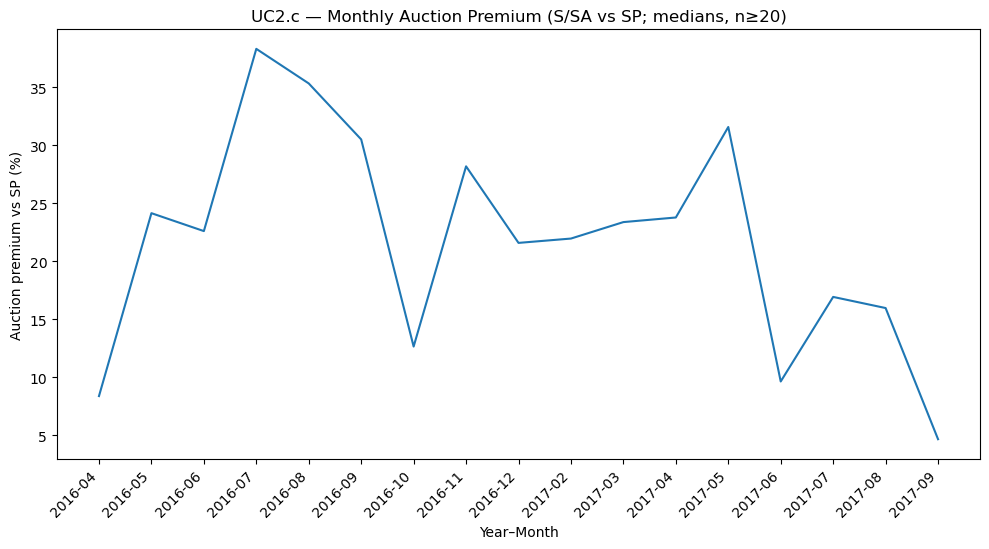

In [206]:
cols = {c.lower(): c for c in df.columns}
SUBURB = cols.get("suburb","Suburb")
PRICE  = cols.get("price","Price")
DATE   = cols.get("date","Date")
METHOD = cols.get("method","Method")
TYPE   = cols.get("type","Type")

df[PRICE] = pd.to_numeric(df[PRICE], errors="coerce")
df[DATE]  = pd.to_datetime(df[DATE], errors="coerce", dayfirst=True)
if TYPE in df.columns: df[TYPE] = df[TYPE].astype(str).str.lower()

d = df[(df[PRICE] > 0) & df[DATE].notna() & df[METHOD].notna()].copy()
d["year_month"] = d[DATE].dt.to_period("M").astype(str)


def method_bucket(m):
    m = str(m).strip().upper()
    if m in {"S","SA"}: return "Auction (S/SA)"
    if m == "SP":      return "Sold prior (SP)"
    if m in {"PI","VB"}: return "Passed/Vendor (PI/VB)"
    return "Other"
d["MethodBucket"] = d[METHOD].apply(method_bucket)


mix = d.groupby(["year_month","MethodBucket"]).size().reset_index(name="n")
mix["share"] = mix["n"] / mix.groupby("year_month")["n"].transform("sum")
mix_piv = mix.pivot(index="year_month", columns="MethodBucket", values="share").fillna(0).sort_index()

plt.figure(figsize=(10,5.6))
mix_piv.plot(kind="bar", stacked=True, ax=plt.gca(), width=0.9)
plt.title("UC2.c — Method Mix by Month")
plt.ylabel("Share of listings"); plt.xlabel("Year–Month")
plt.legend(title="Method", bbox_to_anchor=(1.02,1), loc="upper left")
plt.tight_layout(); plt.show()


sub = d.groupby([SUBURB,"MethodBucket"]).size().reset_index(name="n")
sub["total_n"] = sub.groupby(SUBURB)["n"].transform("sum")
sub["share"]   = sub["n"] / sub["total_n"]
auction_share = sub[sub["MethodBucket"]=="Auction (S/SA)"].copy()
MIN_SUB_N = 60
top_sub = (auction_share[auction_share["total_n"]>=MIN_SUB_N]
           .sort_values(["share","total_n"], ascending=[False,False]).head(15))

plt.figure(figsize=(10,5.6))
plt.bar(top_sub[SUBURB], top_sub["share"]*100)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Auction share (%)")
plt.title(f"UC2.c — Top Suburbs by Auction Share (n≥{MIN_SUB_N})")
plt.tight_layout(); plt.show()


rows = []
for ym, grp in d.groupby("year_month"):
    a = grp[grp["MethodBucket"]=="Auction (S/SA)"][PRICE].dropna()
    p = grp[grp["MethodBucket"]=="Sold prior (SP)"][PRICE].dropna()
    if len(a)>=20 and len(p)>=20:
        prem = a.median() - p.median()
        prem_pct = prem / p.median() * 100
        rows.append({"year_month": ym, "prem_pct": prem_pct,
                     "n_auction": len(a), "n_prior": len(p)})
prem = pd.DataFrame(rows).sort_values("year_month")

if not prem.empty:
    plt.figure(figsize=(10,5.6))
    plt.plot(prem["year_month"], prem["prem_pct"])
    plt.ylabel("Auction premium vs SP (%)")
    plt.xlabel("Year–Month")
    plt.title("UC2.c — Monthly Auction Premium (S/SA vs SP; medians, n≥20)")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout(); plt.show()

In [207]:
report='''
Auction methods (S/SA) dominate most months, accounting for nearly 2/3 of sales; SP (private treaty) has the smallest share, 
while PI/VB fluctuates with market activity. Auction rates are typically higher during peak seasons (spring/early year).

In several suburbs, the auction rate is ≥70%, as shown in the top-ranked suburbs in your chart (those labeled on the right side of the bar chart). 
In these areas, auctions are the dominant sales method: sellers can more easily attract buyers and generate competitive bidding; 
buyers need to prepare their bidding budget and strategy in advance.

Comparing the monthly median price differences between S/SA and SP, a positive "auction premium" often appears; 
in some months, the difference is insignificant. Note that this is a market-level comparison, without controlling for location/property type/size, 
and therefore should not be used as a rule for individual property valuation.
'''
print(report)


Auction methods (S/SA) dominate most months, accounting for nearly 2/3 of sales; SP (private treaty) has the smallest share, 
while PI/VB fluctuates with market activity. Auction rates are typically higher during peak seasons (spring/early year).

In several suburbs, the auction rate is ≥70%, as shown in the top-ranked suburbs in your chart (those labeled on the right side of the bar chart). 
In these areas, auctions are the dominant sales method: sellers can more easily attract buyers and generate competitive bidding; 
buyers need to prepare their bidding budget and strategy in advance.

Comparing the monthly median price differences between S/SA and SP, a positive "auction premium" often appears; 
in some months, the difference is insignificant. Note that this is a market-level comparison, without controlling for location/property type/size, 
and therefore should not be used as a rule for individual property valuation.



In [208]:
report='''
UC2.d — Affordability & Targeting (price bands)
Question: How to segment markets by affordability?
'''
print(report)


UC2.d — Affordability & Targeting (price bands)
Question: How to segment markets by affordability?




Price band thresholds (quantile-based):
     Band     Lower     Upper
 Very Low       NaN  600000.0
      Low  600000.0  800000.0
   Medium  800000.0 1040000.0
     High 1040000.0 1450000.0
Very High 1450000.0       NaN


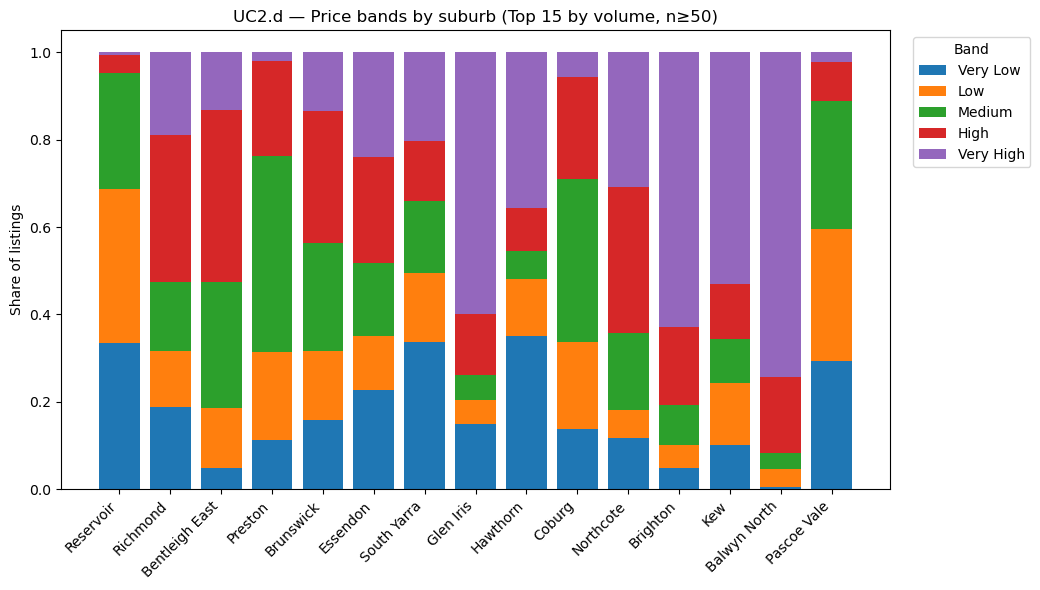

In [214]:
cols   = {c.lower(): c for c in df.columns}
PRICE  = cols.get("price","Price")
SUBURB = cols.get("suburb","Suburb")
TYPE   = cols.get("type","Type")

df[PRICE] = pd.to_numeric(df[PRICE], errors="coerce")
d = df[(df[PRICE] > 0) & df[SUBURB].notna()].copy()
if TYPE in d.columns:
    d = d[d[TYPE].astype(str).str.lower().isin({"h","t","u"})]  


qs     = d[PRICE].quantile([0.2,0.4,0.6,0.8]).to_list()
edges  = [-np.inf] + qs + [np.inf]
labels = ["Very Low","Low","Medium","High","Very High"]
d["Band"] = pd.cut(d[PRICE], bins=edges, labels=labels, include_lowest=True)

thr = pd.DataFrame({"Band": labels,
                    "Lower": [edges[i] for i in range(len(edges)-1)],
                    "Upper": [edges[i+1] for i in range(len(edges)-1)]})
thr_print = thr.copy()
thr_print["Lower"] = thr_print["Lower"].replace([-np.inf], np.nan).round(0)
thr_print["Upper"] = thr_print["Upper"].replace([np.inf],  np.nan).round(0)
print("\nPrice band thresholds (quantile-based):")
print(thr_print.to_string(index=False))


MIN_N = 50  

g = d.groupby([SUBURB, "Band"], observed=True).size().reset_index(name="n")
tot = g.groupby(SUBURB, observed=True)["n"].transform("sum")
g["share"] = g["n"] / tot


stable_n = tot.groupby(g[SUBURB], observed=True).max()
stable_suburbs = stable_n[stable_n >= MIN_N].index
g_stable = g[g[SUBURB].isin(stable_suburbs)].copy()

# Top suburbs by volume
top_suburbs = (g_stable.groupby(SUBURB, observed=True)["n"].sum()
               .sort_values(ascending=False).head(15).index.tolist())


share_wide = (g_stable.pivot_table(index=SUBURB, columns="Band",
                                   values="share", aggfunc="sum", observed=True)
              .reindex(columns=labels).fillna(0))
share_top = share_wide.loc[top_suburbs]


plt.figure(figsize=(10.5, 6))
x = np.arange(len(share_top))
bottom = np.zeros(len(share_top))
for lab in labels:
    vals = share_top[lab].values
    plt.bar(x, vals, bottom=bottom, label=lab)
    bottom += vals
plt.xticks(x, share_top.index, rotation=45, ha="right")
plt.ylabel("Share of listings")
plt.title(f"UC2.d — Price bands by suburb (Top {len(share_top)} by volume, n≥{MIN_N})")
plt.legend(title="Band", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout(); plt.show()

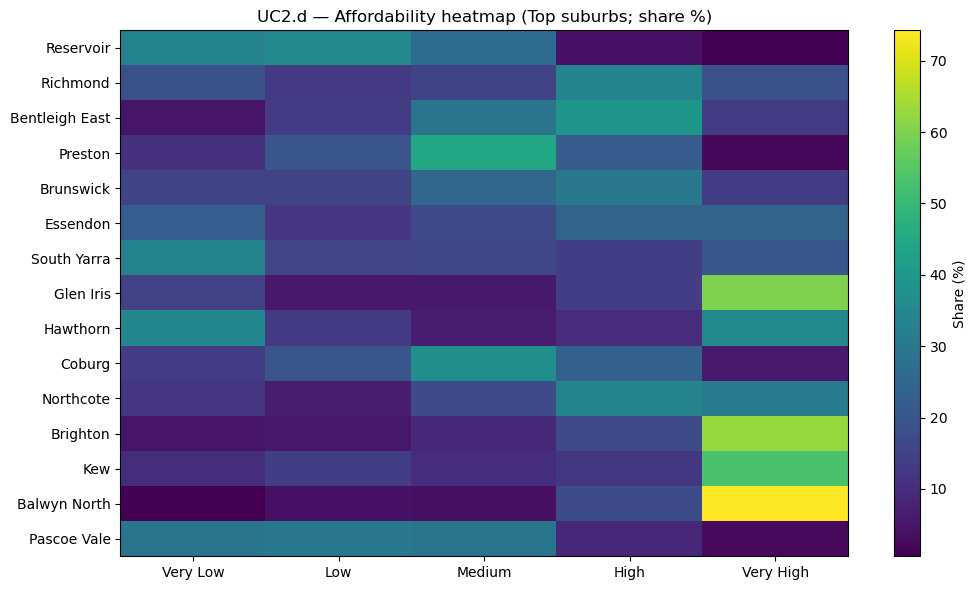

In [215]:
plt.figure(figsize=(10.5, 6))
mat = (share_top * 100).values
im = plt.imshow(mat, aspect="auto", cmap="viridis")
plt.colorbar(im, label="Share (%)")
plt.yticks(np.arange(len(share_top.index)), share_top.index)
plt.xticks(np.arange(len(labels)), labels)
plt.title("UC2.d — Affordability heatmap (Top suburbs; share %)")
plt.tight_layout(); plt.show()

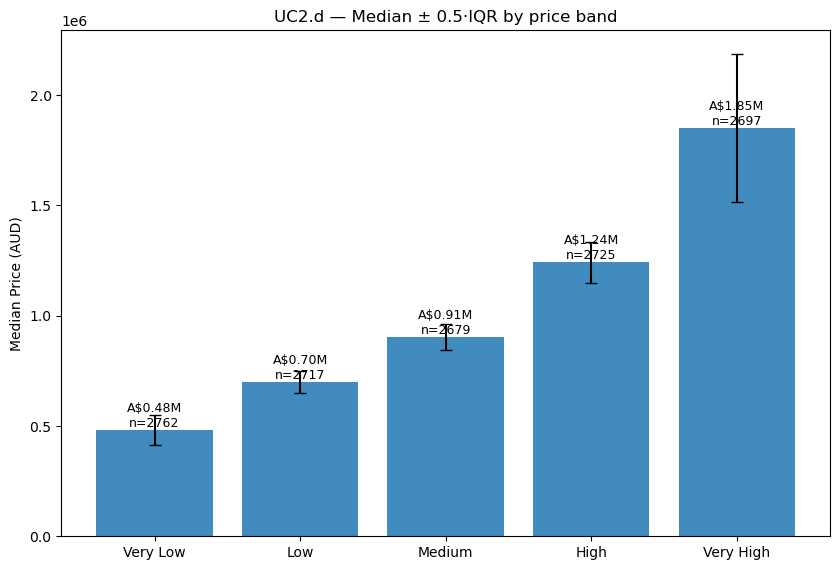

In [216]:
band_stats = (d.groupby("Band", observed=True)[PRICE]
                .agg(median="median",
                     q1=lambda s: s.quantile(0.25),
                     q3=lambda s: s.quantile(0.75),
                     count="size")
                .reindex(labels).reset_index())
band_stats["IQR"] = band_stats["q3"] - band_stats["q1"]

plt.figure(figsize=(8.5, 5.8))
xb = np.arange(len(labels))
plt.bar(xb, band_stats["median"], yerr=band_stats["IQR"]/2, capsize=4, alpha=0.85)
plt.xticks(xb, labels)
plt.ylabel("Median Price (AUD)")
plt.title("UC2.d — Median ± 0.5·IQR by price band")
for i, y in enumerate(band_stats["median"]):
    plt.text(i, y, f"A${y/1_000_000:.2f}M\nn={int(band_stats.loc[i,'count'])}",
             ha="center", va="bottom", fontsize=9)
plt.tight_layout(); plt.show()


In [217]:
low_focus  = (g_stable[g_stable["Band"]=="Very Low"]
              .sort_values("share", ascending=False)
              .head(10)[[SUBURB, "share", "n"]]
              .assign(**{"share(%)": lambda x: (x["share"]*100).round(1)}))
high_focus = (g_stable[g_stable["Band"]=="Very High"]
              .sort_values("share", ascending=False)
              .head(10)[[SUBURB, "share", "n"]]
              .assign(**{"share(%)": lambda x: (x["share"]*100).round(1)}))

print("\nTop suburbs by Very Low share:")
print(low_focus[[SUBURB, "share(%)", "n"]].to_string(index=False))

print("\nTop suburbs by Very High share:")
print(high_focus[[SUBURB, "share(%)", "n"]].to_string(index=False))


Top suburbs by Very Low share:
         Suburb  share(%)  n
       Werribee      80.0 40
         Epping      67.3 35
       St Kilda      55.6 90
  Sunshine West      52.3 45
Heidelberg West      40.8 31
        Windsor      38.3 23
    Maribyrnong      37.5 36
North Melbourne      37.0 30
        Glenroy      36.5 58
      Footscray      36.4 48

Top suburbs by Very High share:
      Suburb  share(%)   n
 Albert Park      76.8  53
   Ashburton      75.0  45
Balwyn North      74.3 127
  Canterbury      70.4  38
      Balwyn      64.5  69
    Brighton      62.9 117
     Hampton      60.8  79
   Glen Iris      60.0 117
  Camberwell      59.1  78
Surrey Hills      58.4  73


In [220]:
report='''
Based on this data (n=13,580), prices were categorized into five bands using quantiles: 
Very Low (<A$600k), Low (A$600k–800k), Medium (A$800k–1.04M), High (A$1.04M–1.45M), and Very High (≥A$1.45M).

The corresponding median prices and interquartile ranges (IQR) were approximately A$482.8k (IQR≈A$138.9k), A$700.0k (≈A$100.0k),
A$905.0k (≈A$118.0k), A$1.242M (≈A$186.0k), and A$1.85M (≈A$670.0k).Higher price bands exhibit greater price volatility and heterogeneity. 

The distribution across the five bands is relatively even (approximately 20% ± 1%: Very Low 20.3%, Low 20.0%, Medium 19.7%, High 20.1%, Very High 19.9%),
but suburban differences are significant: 
Entry-level/affordable areas are represented by Werribee (80.0% Very Low), Epping (67.3%), St Kilda (55.6%), Sunshine West (52.3%), 
and Heidelberg West (40.8%), while premium areas are represented by 
Albert Park (76.8% Very High), Ashburton (75.0%), Balwyn North (74.3%), Canterbury (70.4%), and Balwyn (64.5%).  

In practice, buyers should first identify their price range and prioritize suburbs with a high market share and a narrow IQR within that range. 
Sellers should target their marketing and supply to the corresponding "dominant price band" suburbs.
'''
print(report)


Based on this data (n=13,580), prices were categorized into five bands using quantiles: 
Very Low (<A$600k), Low (A$600k–800k), Medium (A$800k–1.04M), High (A$1.04M–1.45M), and Very High (≥A$1.45M).

The corresponding median prices and interquartile ranges (IQR) were approximately A$482.8k (IQR≈A$138.9k), A$700.0k (≈A$100.0k),
A$905.0k (≈A$118.0k), A$1.242M (≈A$186.0k), and A$1.85M (≈A$670.0k).Higher price bands exhibit greater price volatility and heterogeneity. 

The distribution across the five bands is relatively even (approximately 20% ± 1%: Very Low 20.3%, Low 20.0%, Medium 19.7%, High 20.1%, Very High 19.9%),
but suburban differences are significant: 
Entry-level/affordable areas are represented by Werribee (80.0% Very Low), Epping (67.3%), St Kilda (55.6%), Sunshine West (52.3%), 
and Heidelberg West (40.8%), while premium areas are represented by 
Albert Park (76.8% Very High), Ashburton (75.0%), Balwyn North (74.3%), Canterbury (70.4%), and Balwyn (64.5%).  

In practice, bu